# Layer Car Classification Example

In this notebook, we are going to do a prediction using the models trained by the Car Classification example

In [89]:
# Imports _________________
import layer
import torch
import base64
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision import transforms
from matplotlib.pyplot import imshow
from PIL import Image
from io import BytesIO

In [3]:
# Helper functions _________________
def convert_string_to_image(content):
    return Image.open(BytesIO(base64.b64decode(content)))

In [4]:
layer.login()

## 1. Analyze the `car` dataset
Let's start by analyzing the car dataset. This dataset includes the year and a picture of the car. We can use Layer Dataset interface to easily access this data.

In [5]:
carimages_dataset = layer.get_dataset("carimages")
carimages_df = carimages_dataset.to_pandas()
carimages_df.head()

,id,filename,year,content
0,0,921299981xsz.jpg,2010,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAQDAwQDAwQEAw...
1,1,921299981bu3.jpg,2010,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAQDAwQDAwQEAw...
2,2,9245772016m6.jpg,2017,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAQDAwQDAwQEAw...
3,3,912492711o94.jpg,2006,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAQDAwQDAwQEAw...
4,4,9124927113wu.jpg,2006,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAQDAwQDAwQEAw...


<AxesSubplot:>

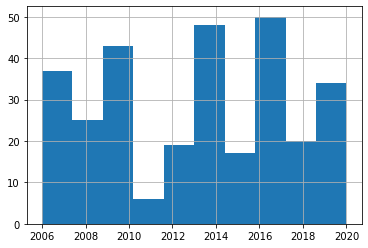

In [46]:
carimages_df.year.hist()

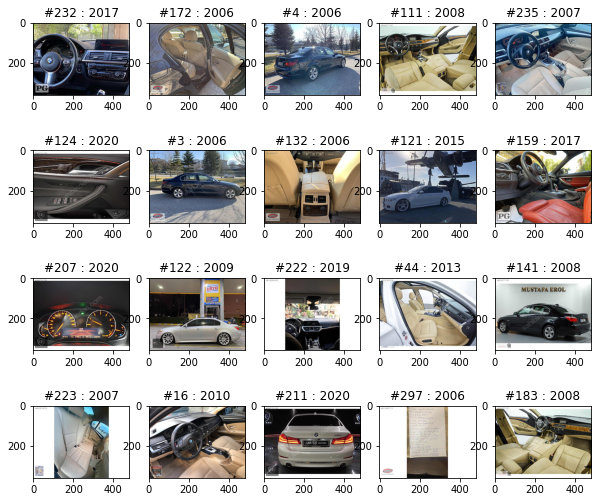

In [105]:
images = []
years = []
index = []
for row in carimages_df.sample(n=20).itertuples():
    images.append(convert_string_to_image(row.content))
    years.append(row.year)
    index.append(row.id)

plt.figure(figsize=(10,9))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title("#"+str(index[i]) + " : " +str(years[i]))
    plt.imshow(images[i])
plt.show()

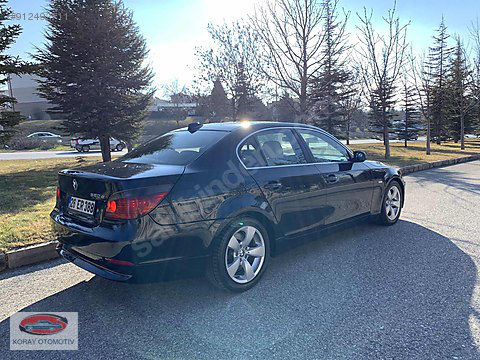

In [131]:
car_id = 4

selected_car = carimages_df.loc[carimages_df['id'] == car_id]
img_bytes = selected_car.content.values[0]
car_image = Image.open(BytesIO(base64.b64decode(img_bytes)))
car_image

## 2. Detect the backlight of the car

We have trained a model; `backlight_detector` which basically helps us detect the backlight of the car. Now, let's fetch this model from Layer Model Catalog and try to detect the backlight of the selected car. We will use the backlight of the car to predict the build year.

In [ ]:
backlight_detector_model = layer.get_model("backlight_detector")
backlight_detector_train = backlight_detector_model.get_train()

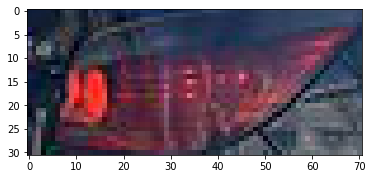

In [132]:
img_tensor = F.to_tensor(car_image)
losses, predictions = backlight_detector_train([img_tensor])

prediction = predictions[0] if (predictions and len(predictions)>0) else None

if prediction and len(prediction['scores'])>0 and prediction['scores'][0]>0.85:
    box = prediction['boxes'][0]
    x1 = float(box[0])
    y1 = float(box[1])
    box_w = float(box[2]) - x1
    box_h = float(box[3]) - y1

    backlight_image = car_image.crop((x1, y1, x1 + box_w, y1 + box_h))
    imshow(backlight_image)
else:
    print("The following image doesn't have any car backlight!")
    imshow(car_image)

## 3. Predict the car build year

Finally, we can use the `car_classifier` model we have trained in this project which predicts the build year of a car from it's backlight image. Once we have the prediction, we can use the `car_label_encoder` model, which is basically a `sklearn.LabelEncoder` model, to get the original, car build year in our case.

In [117]:
car_classifier_model = layer.get_model("car_classifier")
car_classifier_train = car_classifier_model.get_train()

/Users/mehmetecevit/.pyenv/versions/3.8.5/lib/python3.8/site-packages/torch/serialization.py:587: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [133]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)])
    
backlight_image_tensor = train_transforms(backlight_image)
device = ("cuda" if torch.cuda.is_available() else "cpu")
backlight_image_tensor_input = backlight_image_tensor.unsqueeze(0).to(device)

outputs = car_classifier_train(backlight_image_tensor_input)
_, preds = torch.max(outputs, dim=1)
preds

tensor([0])

In [119]:
car_label_encoder = layer.get_model("car_label_encoder")
car_label_encoder_train = car_label_encoder.get_train()

In [134]:
prediction = car_label_encoder_train.inverse_transform(preds)[0]

print(f"Car Build Year: {selected_car.year.values[0]}")
print(f"Predicted Build Year: {prediction}")

Car Build Year: 2006
Predicted Build Year: 2006
